### Project: Analyze fluctuations in HTTP request latency data to determine reliability

Appendix:
- Prepare data:
	- Create sample data from script (data has interval time is 30 second)
- Analyze data
	- Load data (.csv) to dataframe
	- Standardize data
	    - Set index for dataframe is timestamp
	- Explore data
	    - Overview dataset by summary buckets in time series
        - Analyze fluctuations on the dataset
        - Identify issue about latency http request on dataset -> Result about time range issue occur
    - SLI Calculator
        - Simulator rate() on rolling windows
        - Calculate percentile: [50th, 90th, 95th, 99th] or latency in time vector
	
- Apply model

In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

In [43]:
BUCKETS = [0.005, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 2]

In [44]:
# Load dataset from CSV file
root = pd.read_csv('../statics/csv/request_data_with_anomaly_pod_instance.csv', index_col=0)

In [45]:
# Convert to datetime pandas and set datetime columns is index for dataframe
root.index = pd.to_datetime(root.index)
root.head()

,path,method,service_name,controller_pod,0.005,0.01,0.025,0.05,0.1,0.25,0.5,1,2,+Inf
timestamp,,,,,,,,,,,,,,
2024-01-02 10:42:00,/home,GET,process_log,pod-1,0,0,0,0,0,1,1,1,1,1
2024-01-02 10:42:00,/home,GET,process_log,pod-2,0,0,0,0,0,0,1,2,2,2
2024-01-02 10:42:00,/users,GET,process_log,pod-1,0,0,0,0,1,2,3,5,5,5
2024-01-02 10:42:00,/users,GET,process_log,pod-2,0,0,0,0,0,0,2,3,3,3
2024-01-02 10:42:30,/home,GET,process_log,pod-1,0,0,0,0,1,8,12,21,21,21


In [46]:
grouped = ['service_name', 'controller_pod', 'path', 'method']

### Analyze fluctuations on the dataset

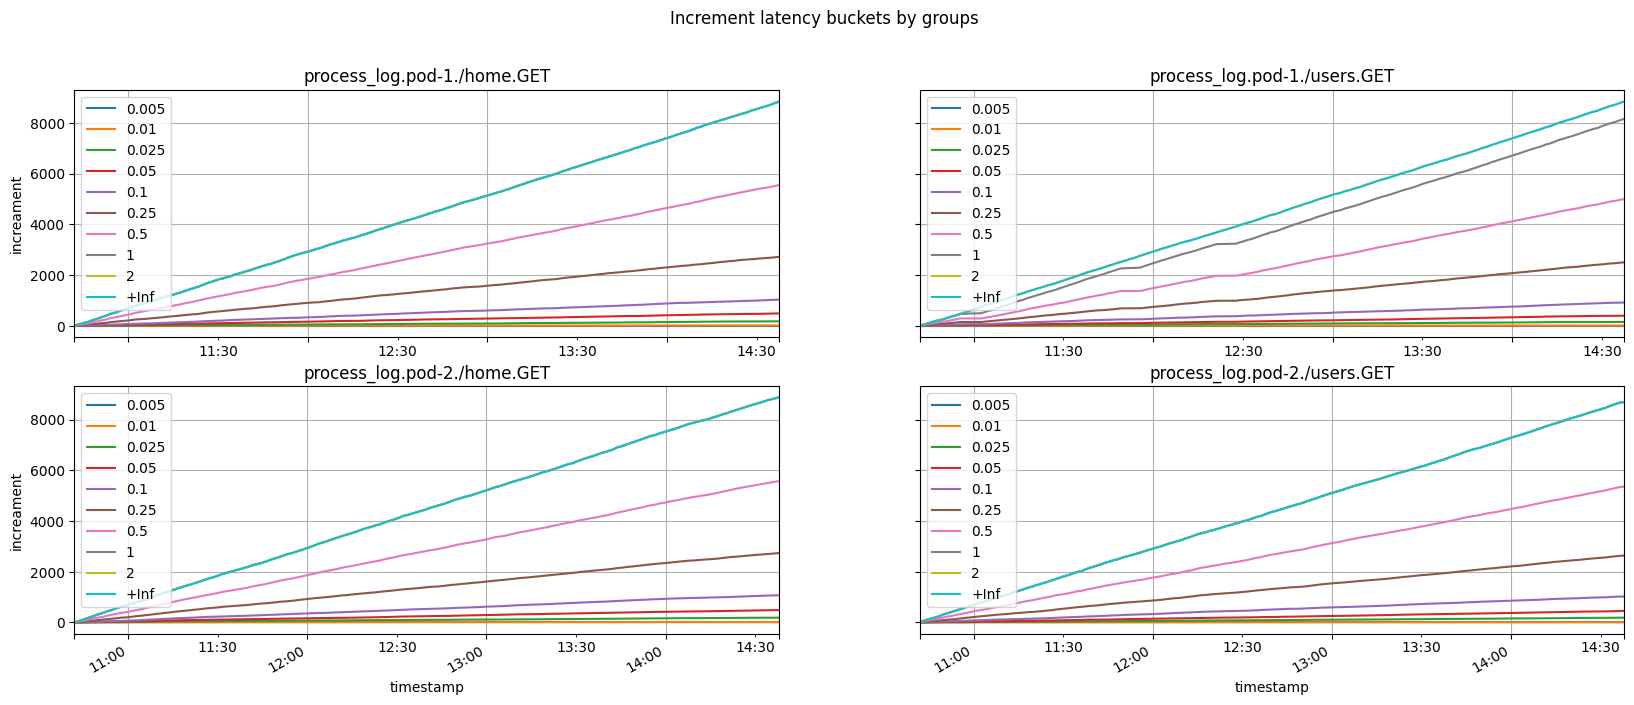

In [47]:
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
chart_data = root.groupby(grouped)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 8), sharey=True)
fig.suptitle('Increment latency buckets by groups')
# Configure x-axis date ticks
locator = AutoDateLocator(minticks=5, maxticks=10)
formatter = AutoDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
for (name, df), ax in zip(chart_data, axes.flat):
    name = ".".join(list(name))
    df.plot(kind="line", ax=ax, title=name, grid=True)
    ax.set(xlabel='timestamp', ylabel='increament')

plt.gcf().autofmt_xdate()
plt.show()

Kết quả cho thấy tăng trưởng trên mối bucket của các group rất đồng đều. Nhưng ở group **process_log.pod-1./users.GET** có 2 đoạn thời gian chỉ tăng trưởng đối với bucket +Inf, còn các bucket khác đều không có tăng trưởng gì. Điều này chứng tỏ trong 2 khoảng thời gian này có những requests chỉ rơi vào các bucket +Inf (nghĩa là duration_time của các requests trong khoảng này đều nằm trong ngưỡng > 1 second)

In [48]:
abnormal_group = "path == '/users' and controller_pod == 'pod-1'"
abnormal_timerange_in_group = ['2024-01-02 11:00:00', '2024-01-02 12:30:00']

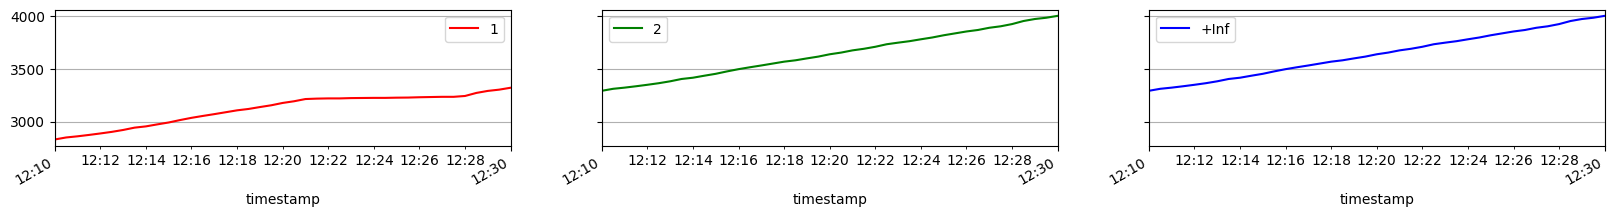

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 2), sharey=True)
buckets_observer = {
    "1": {
        "axe": 0,
        "legend": "le:1",
        "color": "red"
    },
    "2": {
        "axe": 1,
        "legend": "le:2",
        "color": "green"

    },
    "+Inf": {
        "axe": 2,
        "legend": "le:+Inf",
        "color": "blue"
    }
}
for k, v in buckets_observer.items():
    root.query(abnormal_group).loc['2024-01-02 12:10:00':'2024-01-02 12:30:00'][k].plot(
        grid=True, ax=axes[v['axe']], legend=v['legend'], color=v['color']
    )
plt.gcf().autofmt_xdate()
plt.show()

Lúc này có thể thấy rõ hơn được khoảng thời gian và những biến động trong khoảng thời gian đó về việc không có duration_time < 1 second (rơi vào bucket **le:1**)